# Bacterial genomic length vs G+C content

Script for exploratory analysis of microbial genomes. The data directory
should contain the necessary CSV files. Please adjust the pathways below to match your system.

In [2]:
import warnings
from Bio import SeqIO
from Bio.SeqUtils import GC
import gzip
import glob
import os
import os.path
import subprocess as spc
from pathlib import Path
from collections import defaultdict
import csv
import numpy as np
import scipy as sp
import pprint
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
from patsy import dmatrix
import seaborn as sns
import pandas as pd
import pandas_profiling
from fitter import Fitter
from sklearn.cluster import KMeans
import matplotlib
matplotlib.style.use('seaborn-white')
import matplotlib.pyplot as plt
sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.5)
%matplotlib inline
%config InlineBackend.figure_format = 'retina' ## 2x plot resolution

In [3]:
## --------------- Procedure selection -------------------------
## These of course need to be set to True at least once
download_data = False
create_directories = False
initialize_csv_files = False
create_csv_files = False

In [4]:
'''
Script to download all complete microbial genomes from NCBI genbank. All commands are unix/linux shell commands
and can be copied and pasted directly into command prompt if someone wishes to do so. Please be aware, that ncbi
will temporarily block the connection if they deside that there is overuse of the server. They recommend no more
that three requests per second and use of the weekends or holidays (US) for such a purpose.
Thanks to 5heikki at Biostars.org for code recommendations
'''
if download_data:
    '''Set the environment. Change these to your liking'''
    my_path = ('/home/atol/Documents/GC_Content/Data/')
    assembly_file = Path(str(my_path))
    store_path = Path('/home/atol/Documents/GC_Content/Data/Bacteria')


    '''
    Get the list of assemblies if not already present (it might be a good idea
    to delete "assembly_summary.txt" after finishing with fetching the data,
    so a fresh list can be downloded at a later time):
    '''
    if not os.path.isfile(my_path + 'assembly_summary.txt'):
        my_command = ("wget ftp://ftp.ncbi.nlm.nih.gov/genomes/genbank/bacteria/assembly_summary.txt")
        spc.call(my_command, cwd=my_path, shell=True)


    '''Parse the addresses of complete microbial genomes:'''
    parse_command = ('''awk -F '\t' '{if($12=="Complete Genome") print $20}' assembly_summary.txt > assembly_summary_complete_genomes.txt''')
    spc.call(parse_command, cwd=my_path, shell=True)

    '''Make a dir for storing the data'''
    if not os.path.isdir(str(store_path)):
        spc.call('mkdir Bacteria', cwd=my_path, shell=True)

    '''
    Fetch the data.
    The download will send three requests per second (--wait=seconds, as suggested
    by ncbi to avoid abusing the server) and will resume from the last file the
    next time, if for some reason the connection will be lost.
    TODO: progress indication
    '''
    spc.call('''for next in $(cat assembly_summary_complete_genomes.txt);
             do wget --wait=0.3 --continue -P Bacteria "$next"/*genomic.fna.gz
             done''', cwd=my_path, shell=True)

    '''
    The above wget command will also fetch files named:
     ..cds_from_genomic.fna.gz
     ..rna_from_genomic.fna.gz.
     We don't want these, so they must be removed after the downloading finishes:
    '''
    spc.call('''rm -v Bacteria/*cds_from_genomic.fna.gz
             Bacteria/*cds_from_genomic.fna.gz''', cwd=my_path, shell=True)

In [5]:
if create_directories:
    ## Data directory. Change this according to your system
    my_directory = ('/home/atol/Documents/GC_Content/Data')

    ## Place where sequences are stored
    data_dir = (my_directory + '/Bacteria/')

    ## Directory paths to store generated csv and image files
    image_path = (my_directory + '/Images')
    scv_path = (my_directory + '/CSV')

    ## Check if directories exist and if not, create them
    try:
        os.makedirs(image_path)
        os.makedirs(scv_path)
    except OSError:
        if not os.path.isdir(image_path) or not os.path.isdir(scv_path):
            raise

##------------ Initialize the csv files -----------------------
if initialize_csv_files:
    ## The whole dataset
    with open('CSV/MyGC.csv', 'wb') as f_ini:
        headers = ['ID',
                   'Description',
                   'Length',
                   'GC']
        writer = csv.writer(f_ini, delimiter=' ',
                            quoting=csv.QUOTE_NONE,
                            escapechar=" ",
                            doublequote=False)
        writer.writerow(['\t'.join(headers)])

    ## Complete genomes
    with open('CSV/MyGC_genome.csv', 'wb') as f_ini:
        headers = ['ID',
                   'Description',
                   'Length',
                   'GC']
        writer = csv.writer(f_ini, delimiter=' ',
                            quoting=csv.QUOTE_NONE,
                            escapechar=" ",
                            doublequote=False)
        writer.writerow(['\t'.join(headers)])

    ## Plasmids
    with open('CSV/MyGC_plasmid.csv', 'wb') as f_ini:
        headers = ['ID',
                   'Description',
                   'Length',
                   'GC']
        writer = csv.writer(f_ini, delimiter=' ',
                            quoting=csv.QUOTE_NONE,
                            escapechar=" ",
                            doublequote=False)
        writer.writerow(['\t'.join(headers)])

    ## Phage
    with open('CSV/MyGC_phage.csv', 'wb') as f_ini:
        headers = ['ID',
                   'Description',
                   'Length',
                   'GC']
        writer = csv.writer(f_ini, delimiter=' ',
                            quoting=csv.QUOTE_NONE,
                            escapechar=" ",
                            doublequote=False)
        writer.writerow(['\t'.join(headers)])
    
    ## Names only
    with open('CSV/MyGC_hostnames.csv', 'wb') as pairs:
        headers = ['Host names']
        writer = csv.writer(pairs, delimiter=' ',
                            quoting=csv.QUOTE_NONE,
                            escapechar=" ",
                            doublequote=False)
        writer.writerow(['\t'.join(headers)])


if create_csv_files:
    ## --------------------- Extract the files -------------------------

    for gzip_path in glob.glob("%s/*.fna.gz" % data_dir):
        if not os.path.isdir(gzip_path):
            with gzip.open(gzip_path, 'rb') as in_file:
                s = in_file.read()

            # Now store the uncompressed data
            path_to_store = gzip_path[:-3]  # remove the '.gz' from the filename

            # store uncompressed file data from 's' variable
            with open(path_to_store, 'w') as g:
                g.write(' '.join(s.split(',')))  ## remove any commas from Description

        ## ----------- Write the entries into separate csv's ------------------------
        """
        The code below can be more elegant and short. It is my opinion though,
        it is more readable the way it is, and that's what counts, as long as
        it does not affect performance.
        """

        ## ----------- Select the complete entries ---------------------------
        records = list(SeqIO.parse(path_to_store, "fasta"))
        
        with open('CSV/MyGC.csv', 'a+') as f:
            for record in records:
                record.description = ' '.join(record.description.split()[1:])
                rec = [record.id,
                       record.description,
                       str(len(record)),
                       str(GC(record.seq))]
                ## Filter for incomplete entries and write
                if "complete" in record.description:
                    writer = csv.writer(f, delimiter=' ',
                                        quoting=csv.QUOTE_NONE,
                                        escapechar=" ",
                                        doublequote=False)
                    writer.writerow(['\t'.join(rec)])

## ----------- Select the gemomes -------------------------------------------
        with open('CSV/MyGC_genome.csv', 'a+') as f:
            for record in records:
                rec = [record.id,
                       record.description,
                       str(len(record)),
                       str(GC(record.seq))]
                ## Filter for incomplete entries and write
                if "genome" in record.description and len(record) > plasmid_length_threshold: ## Check for plasmids with wrong annotation
                    if "complete" in record.description:
                        if not "plasmid" in record.description:
                            if not "phage" in record.description:
                                if not "putative" in record.description:
                                    writer = csv.writer(f, delimiter=' ',
                                                        quoting=csv.QUOTE_NONE,
                                                        escapechar=" ",
                                                        doublequote=False)
                                    writer.writerow(['\t'.join(rec)])

## ------------- Select plasmids from the annotation ------------------------
        with open('CSV/MyGC_plasmid.csv', 'a+') as f:
            for record in records:
                rec = [record.id,
                       record.description,
                       str(len(record)),
                       str(GC(record.seq))]
                ## Filter for incomplete entries and write
                if "plasmid" in record.description:
                    if "complete" in record.description:
                        if not "putative" in record.description:
                            writer = csv.writer(f, delimiter=' ',
                                                quoting=csv.QUOTE_NONE,
                                                escapechar=" ",
                                                doublequote=False)
                            writer.writerow(['\t'.join(rec)])
                            ## Account for misannotated entries
                elif "genome" in record.description and (len(record) < plasmid_length_threshold):
                    if "complete" in record.description:
                        if not "putative" in record.description:
                            writer = csv.writer(f, delimiter=' ',
                                                quoting=csv.QUOTE_NONE,
                                                escapechar=" ",
                                                doublequote=False)
                            writer.writerow(['\t'.join(rec)])
                            
## ------------ Select phages ------------------------------------------------
        with open('CSV/MyGC_phage.csv', 'a+') as f:
            for record in records:
                rec = [record.id,
                       record.description,
                       str(len(record)),
                       str(GC(record.seq))]
                ## Filter for incomplete entries and write
                if "phage" in record.description:
                    if "complete" in record.description:
                        if not "putative" in record.description:
                            writer = csv.writer(f, delimiter=' ',
                                                quoting=csv.QUOTE_NONE,
                                                escapechar=" ",
                                                doublequote=False)
                            writer.writerow(['\t'.join(rec)])

Data directory. Change these accordingly

In [6]:
my_directory = ('/home/atol/Documents/GC_Content/Data')
image_path = (my_directory + '/Images')
csv_path = (my_directory + '/CSV')

The directory "CSV2" (or whatever) should contain four csv files:  

MyGC.csv (Every sequence)  
MyGC_genomes.csv (Genomic sequences only)  
MyGC_plasmid.csv (Plasmids)  
MyGC_phage.csv (Phage sequences)  

From these, we create separate dataframes with Pandas.

In [7]:
MyGC_sep = pd.read_csv(csv_path + '/MyGC.csv', sep='\t', index_col='ID')
MyGC_genome = pd.read_csv(csv_path + '/MyGC_genome.csv', sep='\t', index_col='ID')
MyGC_plasmid = pd.read_csv(csv_path + '/MyGC_plasmid.csv', sep='\t', index_col='ID')
MyGC_phage = pd.read_csv(csv_path + '/MyGC_phage.csv', sep='\t', index_col='ID')

In [8]:
print 'Entries in the whole dataset: ', len(MyGC_sep)
print 'Entries in "genome" set: ', len(MyGC_genome)
print 'Entries in "plasmid" set: ', len(MyGC_plasmid)
print 'Entries in "phage" set: ', len(MyGC_phage)

Entries in the whole dataset:  13429
Entries in "genome" set:  6671
Entries in "plasmid" set:  5744
Entries in "phage" set:  9


Plasmid (and phages) number vary accross organisms. Some have none, while others contain a varying number of them. Therefore, the dataframes cannot be used as they are. Instead, we have to create lists, containing each plasmid found, paired with its host:

In [9]:
Pairs_length = []
Pairs_GC = [] 
Phage_Pairs_length = []
Phage_Pairs_GC = []

## The names will be needed later
Pairs_name = []
Phage_Pairs_name = []

for i in MyGC_plasmid.itertuples():
    pname = ' '.join(i[1].split()[:-2])
    plasmid_name = ' '.join(pname.split()[:6])
    for entry in MyGC_genome.itertuples():
        ## clean the names from "complete genome" etc
        name = ' '.join(entry[1].split()[:-2])
        host_name = ' '.join(name.split()[:5])
        if host_name in plasmid_name:
            if not 'putative' in plasmid_name:
                Pairs_length.append([entry[2], i[2]])
                Pairs_GC.append([entry[3], i[3]])
                Pairs_name.append(plasmid_name)

for i in MyGC_phage.itertuples():
    pname = ' '.join(i[1].split()[:-2])
    phage_name = ' '.join(pname.split()[:1])
    for entry in MyGC_genome.itertuples():
        ## clean the names from "complete genome" etc
        name = ' '.join(entry[1].split()[:-2])
        host_name = ' '.join(name.split()[:5])
        if phage_name in host_name:
            if not 'putative' in phage_name:
                Phage_Pairs_length.append([entry[2], i[2]])
                Phage_Pairs_GC.append([entry[3], i[3]])
                Phage_Pairs_name.append(phage_name)

...and append these lists to new dataframes for convenience:

In [10]:
dfm_GC = pd.DataFrame.from_records(Pairs_GC, columns=['Host', 'Plasmid'])
dfm_phage_GC = pd.DataFrame.from_records(Phage_Pairs_GC, columns=['Host', 'Phage'])

## All data

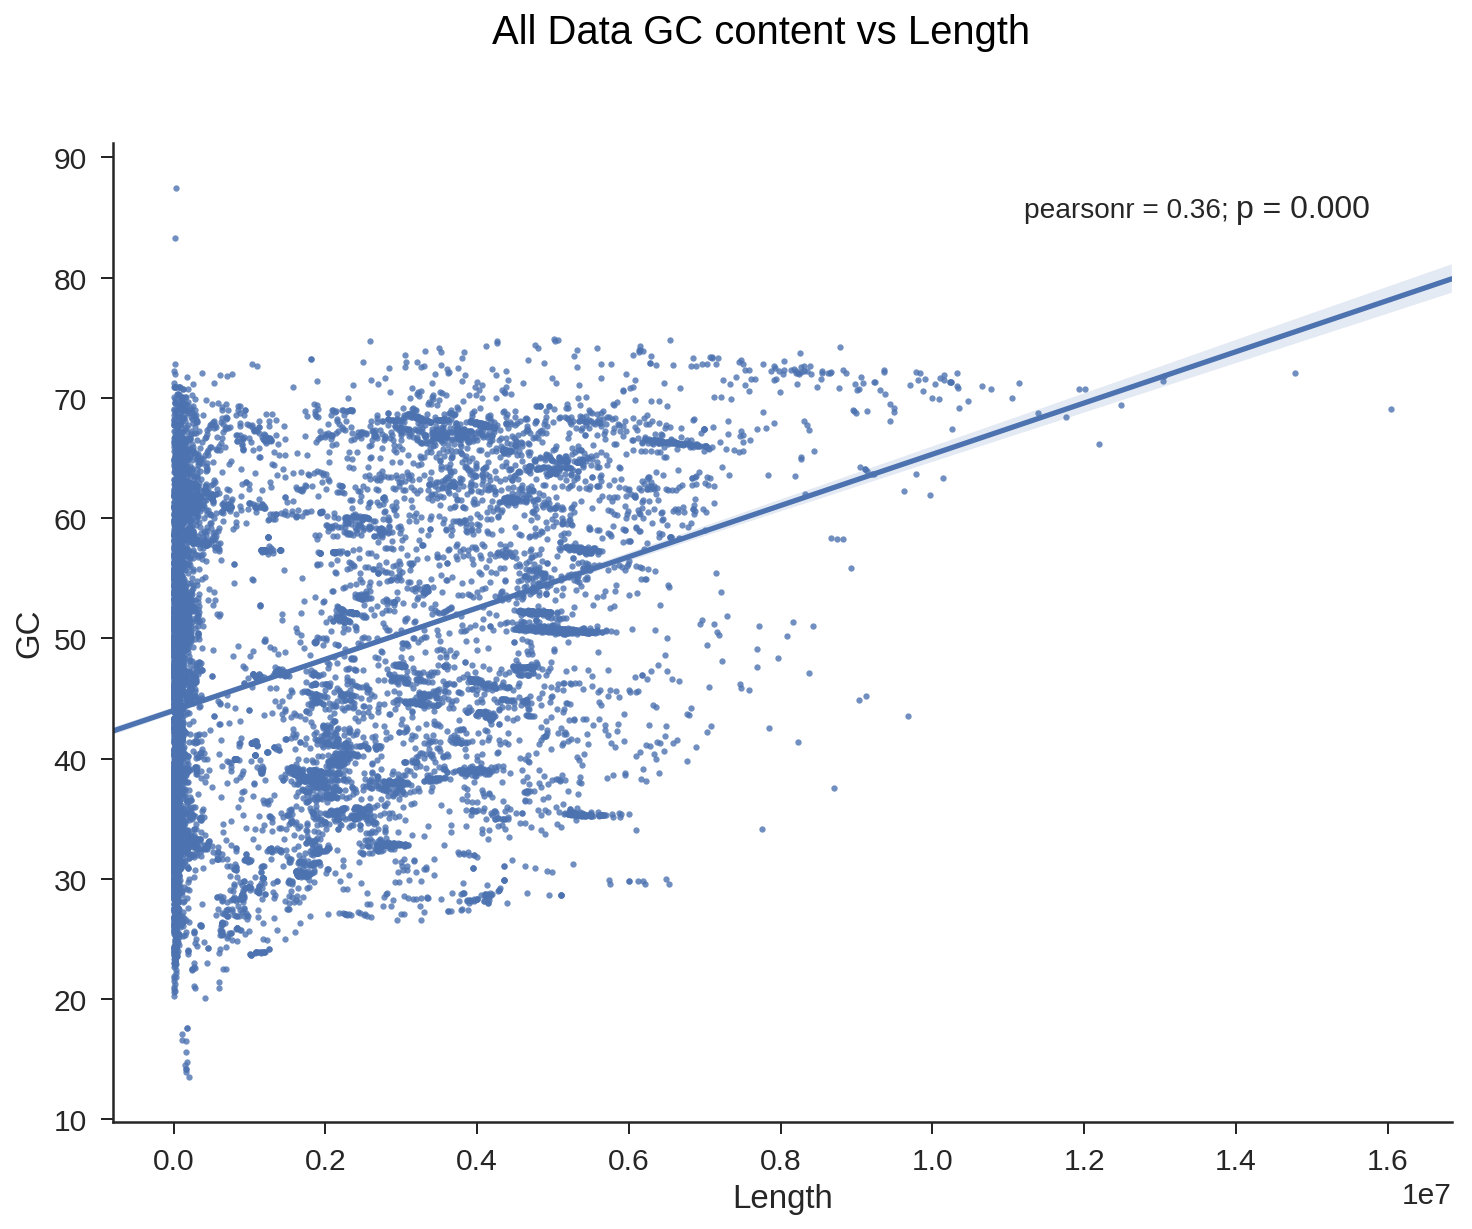

In [11]:
pr = stats.pearsonr(MyGC_sep.Length, MyGC_sep.GC)
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
sns.regplot(MyGC_sep.Length, MyGC_sep.GC, scatter_kws={'s':10}, ax=ax)
ax.annotate('pearsonr = %.2f;' % pr[0], xy=(1.12e7, 85), fontsize=14)
ax.annotate('p = %.3f' % pr[1], xy=(1.4e7, 85), fontsize=16)
fig.suptitle('All Data GC content vs Length', fontsize=20, color="k")
matplotlib.pyplot.savefig('Images2/all.png', bbox_inches='tight')
matplotlib.pyplot.savefig('Images2/all.pdf', format='pdf', dpi=300, bbox_inches='tight')
sns.despine()

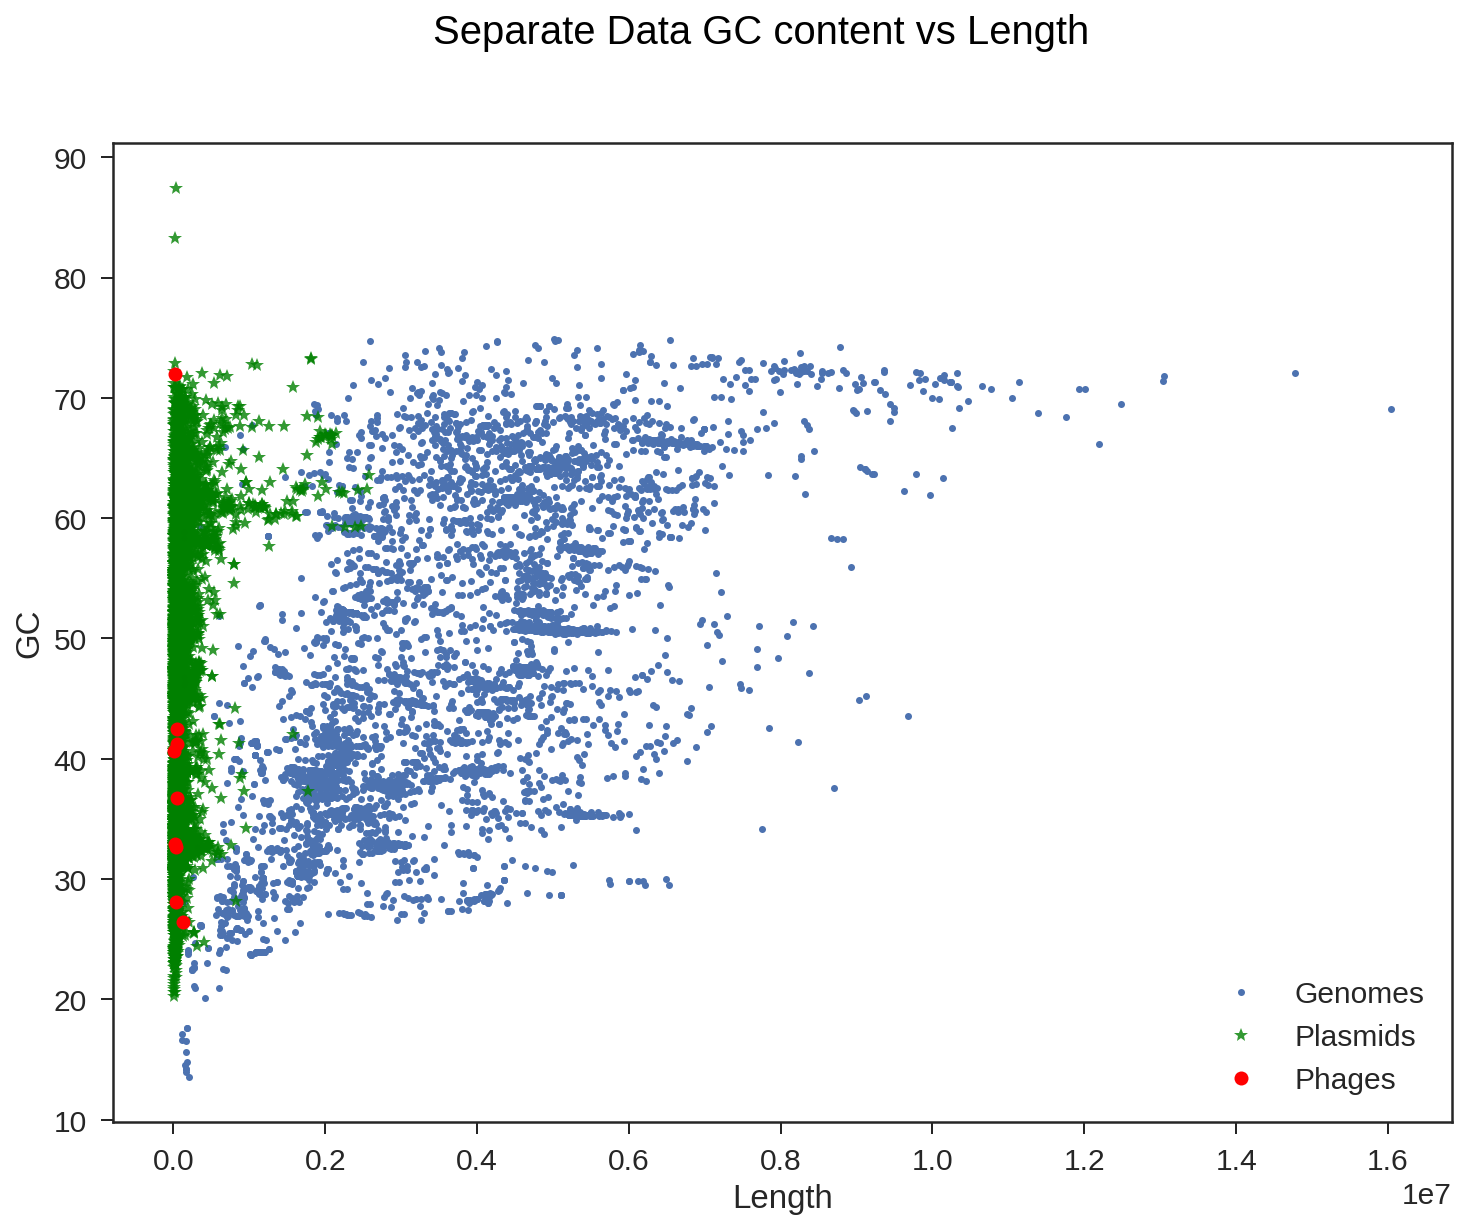

In [12]:
x_data = MyGC_genome.Length
y_data = MyGC_genome.GC
xp_data = MyGC_plasmid.Length
yp_data = MyGC_plasmid.GC
xh_data = MyGC_phage.Length
yh_data = MyGC_phage.GC

fig2 = plt.figure(figsize=(12, 9))
plt.plot(x_data, y_data, '.', label='Genomes')
plt.plot(xp_data, yp_data, '*', color='g', alpha=0.8, label='Plasmids')
plt.plot(xh_data, yh_data, 'o', color='r', label='Phages')
plt.ylabel('GC')
plt.xlabel('Length')
plt.legend(loc=4)
fig2.suptitle('Separate Data GC content vs Length', fontsize=20, color="k")
matplotlib.pyplot.savefig('Images2/all_sep.png', bbox_inches='tight')
matplotlib.pyplot.savefig('Images2/all_sep.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


## Genomes

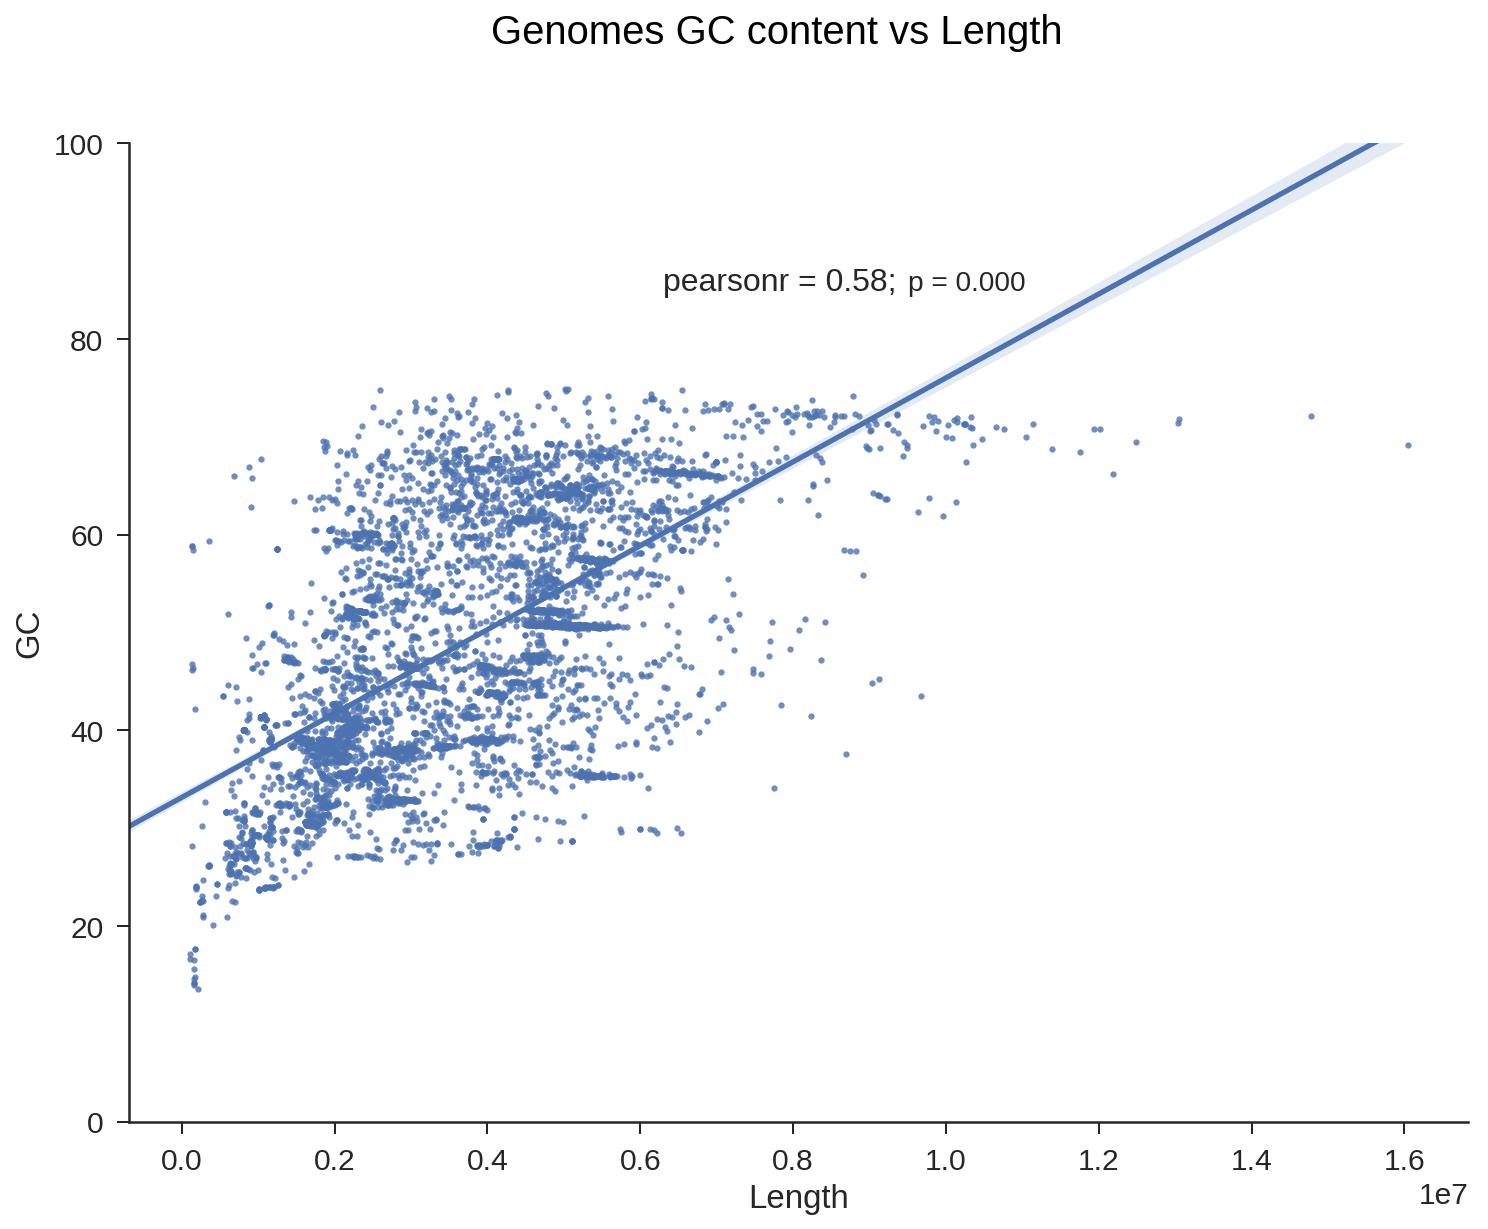

In [13]:
pr = stats.pearsonr(MyGC_genome.Length, MyGC_genome.GC)
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)
axes = plt.gca()
sns.regplot(MyGC_genome.Length, MyGC_genome.GC, scatter_kws={'s':10}, ax=ax)
ax.annotate('pearsonr = %.2f;' % pr[0], xy=(0.63e7, 85), fontsize=16)
ax.annotate('p = %.3f' % pr[1], xy=(0.95e7, 85), fontsize=14)
axes.set_ylim([0,100])
fig.suptitle('Genomes GC content vs Length', fontsize=20, color="k")
matplotlib.pyplot.savefig('Images2/genomes.png', bbox_inches='tight')
matplotlib.pyplot.savefig('Images2/genomes.pdf', format='pdf', dpi=300, bbox_inches='tight')
sns.despine()

## Plasmids

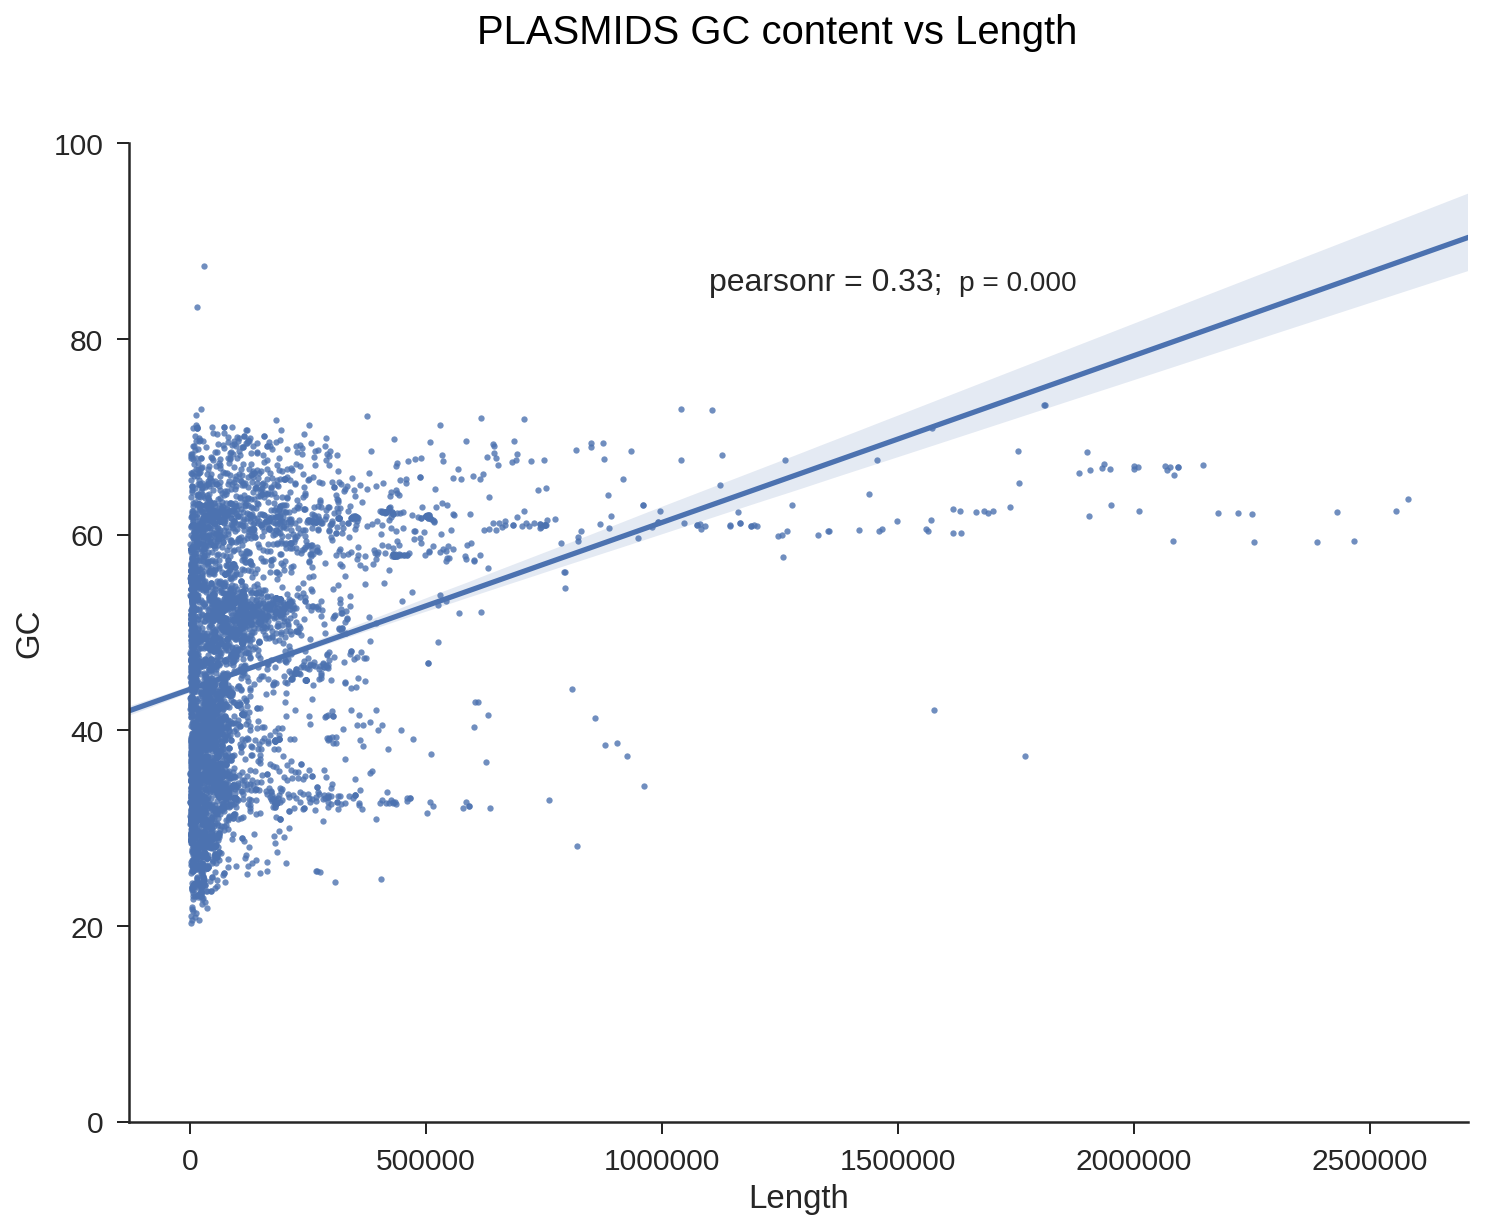

In [14]:
pr_plas = stats.pearsonr(MyGC_plasmid.Length, MyGC_plasmid.GC)
fig2, ax = plt.subplots()
fig2.set_size_inches(12, 9)
axes = plt.gca()
sns.regplot(MyGC_plasmid.Length, MyGC_plasmid.GC, scatter_kws={'s':10}, ax=ax)
ax.annotate('pearsonr = %.2f;' % pr_plas[0], xy=(0.11e7, 85), fontsize=16)
ax.annotate('p = %.3f' % pr_plas[1], xy=(0.163e7, 85), fontsize=14)
axes.set_ylim([0,100])
fig2.suptitle('PLASMIDS GC content vs Length', fontsize=20, color="k")
sns.despine()
matplotlib.pyplot.savefig('Images2/plasmids.png', bbox_inches='tight')
matplotlib.pyplot.savefig('Images2/plasmids.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Phages

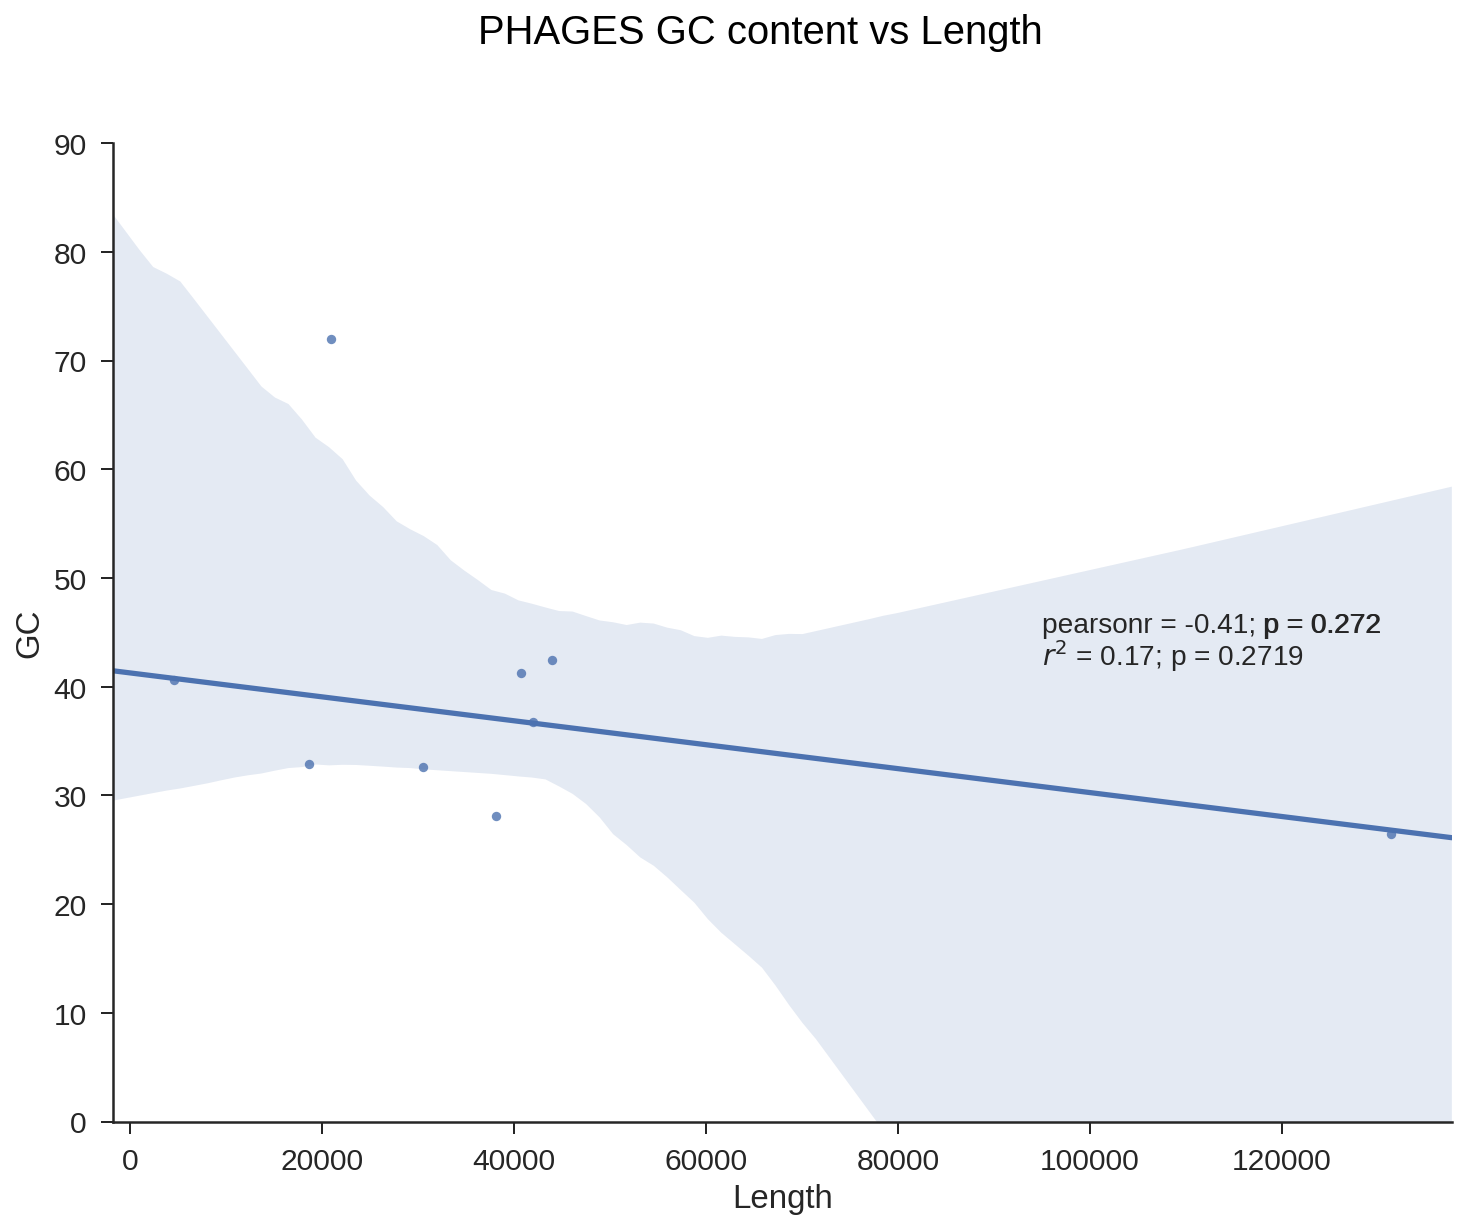

In [16]:
pr_phag = stats.pearsonr(MyGC_phage.Length, MyGC_phage.GC)
fig3, ax = plt.subplots()
fig3.set_size_inches(12, 9)
axes = plt.gca()
sns.regplot(MyGC_phage.Length, MyGC_phage.GC, scatter_kws={'s':22}, ax=ax, robust=True)
ax.annotate('pearsonr = %.2f; p = %.3f' %(pr_phag[0], pr_phag[1]), xy=(0.095e6, 45), fontsize=14)
ax.annotate('p = %.3f' % pr_phag[1], xy=(0.118e6, 45), fontsize=14)
ax.annotate('$r^2$ = %.2f; p = %.4f' %(pr_phag[0]**2, pr_phag[1]), xy=(0.095e6, 42), fontsize=14)
axes.set_ylim([0,90])
fig3.suptitle('PHAGES GC content vs Length', fontsize=20, color="k")
sns.despine()
matplotlib.pyplot.savefig('Images2/phages.png', bbox_inches='tight')
matplotlib.pyplot.savefig('Images2/phages.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Quantitative analysis

Get the low-high numbers for each data set:

In [17]:
from IPython.display import display, Markdown, Latex

## ---------- Extreme ends of sorted dataframes (GC) ----------------
## All data
all_ext_high_GC_temp = MyGC_sep.sort_values('GC', ascending=0).head(5)
all_ext_low_GC_temp = MyGC_sep.sort_values('GC').head(5)
all_ext_high_L_temp = MyGC_sep.sort_values('Length', ascending=0).head(5)
all_ext_low_L_temp = MyGC_sep.sort_values('Length').head(5)
## Genomes
gen_ext_high_GC_temp = MyGC_genome.sort_values('GC', ascending=0).head(5)
gen_ext_low_GC_temp = MyGC_genome.sort_values('GC').head(5)
gen_ext_high_L_temp = MyGC_genome.sort_values('Length', ascending=0).head(5)
gen_ext_low_L_temp = MyGC_genome.sort_values('Length').head(5)
## Plasmids
plasm_ext_high_GC_temp = MyGC_plasmid.sort_values('GC', ascending=0).head(5)
plasm_ext_low_GC_temp = MyGC_plasmid.sort_values('GC').head(5)
plasm_ext_high_L_temp = MyGC_plasmid.sort_values('Length', ascending=0).head(5)
plasm_ext_low_L_temp = MyGC_plasmid.sort_values('Length').head(5)
## Phages
phag_ext_high_GC_temp = MyGC_phage.sort_values('GC', ascending=0).head(20)
phag_ext_high_L_temp = MyGC_phage.sort_values('Length', ascending=0).head(20)

## ---- Lists --------
## All data
all_ext_high_GC_lst = []
all_ext_low_GC_lst = []
all_ext_high_L_lst = []
all_ext_low_L_lst = []
## Genomes
gen_ext_high_GC_lst = []
gen_ext_low_GC_lst = []
gen_ext_high_L_lst = []
gen_ext_low_L_lst = []
## Plasmids
plasm_ext_high_GC_lst = []
plasm_ext_low_GC_lst = []
plasm_ext_high_L_lst = []
plasm_ext_low_L_lst = []
## Phages
phag_ext_high_GC_lst = []
phag_ext_high_L_lst = []

## ------------ Extract the data -----------------------
## All data
for item in all_ext_high_GC_temp.itertuples():
    all_ext_high_GC_lst.append([str(item[1]), item[2], item[3]])
for item in all_ext_low_GC_temp.itertuples():
    all_ext_low_GC_lst.append([str(item[1]), item[2], item[3]])
for item in all_ext_high_L_temp.itertuples():
    all_ext_high_L_lst.append([str(item[1]), item[2], item[3]])
for item in all_ext_low_L_temp.itertuples():
    all_ext_low_L_lst.append([str(item[1]), item[2], item[3]])
## Genomes
for item in gen_ext_high_GC_temp.itertuples():
    gen_ext_high_GC_lst.append([str(item[1]), item[2], item[3]])
for item in gen_ext_low_GC_temp.itertuples():
    gen_ext_low_GC_lst.append([str(item[1]), item[2], item[3]])
for item in gen_ext_high_L_temp.itertuples():
    gen_ext_high_L_lst.append([str(item[1]), item[2], item[3]])
for item in gen_ext_low_L_temp.itertuples():
    gen_ext_low_L_lst.append([str(item[1]), item[2], item[3]])
## Plasmids
for item in plasm_ext_high_GC_temp.itertuples():
    plasm_ext_high_GC_lst.append([str(item[1]), item[2], item[3]])
for item in plasm_ext_low_GC_temp.itertuples():
    plasm_ext_low_GC_lst.append([str(item[1]), item[2], item[3]])
for item in plasm_ext_high_L_temp.itertuples():
    plasm_ext_high_L_lst.append([str(item[1]), item[2], item[3]])
for item in plasm_ext_low_L_temp.itertuples():
    plasm_ext_low_L_lst.append([str(item[1]), item[2], item[3]])
## Phages
for item in phag_ext_high_GC_temp.itertuples():
    phag_ext_high_GC_lst.append([str(item[1]), item[2], item[3]])
for item in phag_ext_high_L_temp.itertuples():
    phag_ext_high_L_lst.append([str(item[1]), item[2], item[3]])

## ----------- Back to dataframes -------------------------
## All data    
all_ext_high_GC_df = pd.DataFrame.from_records(all_ext_high_GC_lst, columns=['Description', 'Length', 'GC'])
all_ext_low_GC_df = pd.DataFrame.from_records(all_ext_low_GC_lst, columns=['Description', 'Length', 'GC'])
all_ext_high_L_df = pd.DataFrame.from_records(all_ext_high_L_lst, columns=['Description', 'Length', 'GC'])
all_ext_low_L_df = pd.DataFrame.from_records(all_ext_low_L_lst, columns=['Description', 'Length', 'GC'])
## Genomes    
gen_ext_high_GC_df = pd.DataFrame.from_records(gen_ext_high_GC_lst, columns=['Description', 'Length', 'GC'])
gen_ext_low_GC_df = pd.DataFrame.from_records(gen_ext_low_GC_lst, columns=['Description', 'Length', 'GC'])
gen_ext_high_L_df = pd.DataFrame.from_records(gen_ext_high_L_lst, columns=['Description', 'Length', 'GC'])
gen_ext_low_L_df = pd.DataFrame.from_records(gen_ext_low_L_lst, columns=['Description', 'Length', 'GC'])
## Plasmids   
plasm_ext_high_GC_df = pd.DataFrame.from_records(plasm_ext_high_GC_lst, columns=['Description', 'Length', 'GC'])
plasm_ext_low_GC_df = pd.DataFrame.from_records(plasm_ext_low_GC_lst, columns=['Description', 'Length', 'GC'])
plasm_ext_high_L_df = pd.DataFrame.from_records(plasm_ext_high_L_lst, columns=['Description', 'Length', 'GC'])
plasm_ext_low_L_df = pd.DataFrame.from_records(plasm_ext_low_L_lst, columns=['Description', 'Length', 'GC'])
## Phages    
phag_ext_high_GC_df = pd.DataFrame.from_records(phag_ext_high_GC_lst, columns=['Description', 'Length', 'GC'])
phag_ext_high_L_df = pd.DataFrame.from_records(phag_ext_high_L_lst, columns=['Description', 'Length', 'GC'])

Add latex output to pandas Dataframe class:

In [18]:
pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return "\centering{%s}" % self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame

Allow for full lenght of text (100 characters here)

In [19]:
pd.options.display.max_colwidth = 100

### Extreme values for the whole dataset

#### GC content

In [20]:
display(all_ext_high_GC_df, all_ext_low_GC_df)

Description  \
0  Streptomyces  autolyticus  strain  CGMCC0516  plasmid  unnamed3  complete  sequence   
1  Streptomyces  autolyticus  strain  CGMCC0516  plasmid  unnamed8  complete  sequence   
2                              Anaeromyxobacter  dehalogenans  2CP-C  complete  genome   
3                                           Anaeromyxobacter  sp.  K  complete  genome   
4                     Streptomyces  rubrolavendulae  strain  MJM4426  complete  genome   

    Length         GC  
0    30888  87.477337  
1    15591  83.285229  
2  5013479  74.905270  
3  5061632  74.840684  
4  6543262  74.784335

Description  \
0                Candidatus  Zinderia  insecticola  CARI  complete  genome   
1  Candidatus  Carsonella  ruddii  CE  isolate  Thao2000  complete  genome   
2  Candidatus  Carsonella  ruddii  HC  isolate  Thao2000  complete  genome   
3  Candidatus  Carsonella  ruddii  CS  isolate  Thao2000  complete  genome   
4  Candidatus  Carsonella  ruddii  HT  isolate  Thao2000  complete  genome   

   Length         GC  
0  208564  13.538770  
1  162589  13.975730  
2  166163  14.177645  
3  162504  14.184882  
4  157543  14.550313

#### Length

In [21]:
display(all_ext_high_L_df, all_ext_low_L_df)

Description    Length  \
0   Minicystis  rosea  strain  DSM  24000  complete  genome  16040666   
1         Sorangium  cellulosum  So0157-2  complete  genome  14782125   
2            Nonomuraea  sp.  ATCC  55076  complete  genome  13047416   
3     Sorangium  cellulosum  'So  ce  56'  complete  genome  13033779   
4  Archangium  gephyra  strain  DSM  2261  complete  genome  12489432   

          GC  
0  69.102337  
1  72.101839  
2  71.808655  
3  71.375738  
4  69.448771

Description  \
0                    Candidatus  Tremblaya  phenacola  PAVE  plasmid  complete  sequence   
1      Lactococcus  lactis  subsp.  lactis  KLDS  4.0325  plasmid  2  complete  sequence   
2  Enterococcus  faecium  strain  ISMMS_VRE_1  plasmid  ISMMS_VRE_p5  complete  sequence   
3           Borreliella  garinii  strain  CIP  103362  plasmid  cp32  complete  sequence   
4         Acinetobacter  baumannii  strain  JBA13  plasmid  pJBA13_2  complete  sequence   

   Length         GC  
0     744  42.204301  
1     870  32.643678  
2     886  31.264108  
3    1085  30.414747  
4    1109  59.062218

### Extreme GC values for genomes

#### GC content

In [22]:
display(gen_ext_high_GC_df, gen_ext_low_GC_df)

Description   Length  \
0           Anaeromyxobacter  dehalogenans  2CP-C  complete  genome  5013479   
1                        Anaeromyxobacter  sp.  K  complete  genome  5061632   
2  Streptomyces  rubrolavendulae  strain  MJM4426  complete  genome  6543262   
3          Corynebacterium  sphenisci  DSM  44792  complete  genome  2594799   
4                   Cellulomonas  fimi  ATCC  484  complete  genome  4266344   

          GC  
0  74.905270  
1  74.840684  
2  74.784335  
3  74.729603  
4  74.724331

Description  \
0                Candidatus  Zinderia  insecticola  CARI  complete  genome   
1  Candidatus  Carsonella  ruddii  CE  isolate  Thao2000  complete  genome   
2  Candidatus  Carsonella  ruddii  HC  isolate  Thao2000  complete  genome   
3  Candidatus  Carsonella  ruddii  CS  isolate  Thao2000  complete  genome   
4  Candidatus  Carsonella  ruddii  HT  isolate  Thao2000  complete  genome   

   Length         GC  
0  208564  13.538770  
1  162589  13.975730  
2  166163  14.177645  
3  162504  14.184882  
4  157543  14.550313

#### Length

In [23]:
display(gen_ext_high_L_df, gen_ext_low_L_df)

Description    Length  \
0   Minicystis  rosea  strain  DSM  24000  complete  genome  16040666   
1         Sorangium  cellulosum  So0157-2  complete  genome  14782125   
2            Nonomuraea  sp.  ATCC  55076  complete  genome  13047416   
3     Sorangium  cellulosum  'So  ce  56'  complete  genome  13033779   
4  Archangium  gephyra  strain  DSM  2261  complete  genome  12489432   

          GC  
0  69.102337  
1  72.101839  
2  71.808655  
3  71.375738  
4  69.448771

Description  \
0   Candidatus  Nasuia  deltocephalinicola  strain  PUNC  complete  genome   
1  Candidatus  Nasuia  deltocephalinicola  str.  NAS-ALF  complete  genome   
2    Candidatus  Hodgkinia  cicadicola  isolate  TETUND1  complete  genome   
3                  Candidatus  Tremblaya  princeps  PCIT  complete  genome   
4                 Candidatus  Tremblaya  princeps  PCVAL  complete  genome   

   Length         GC  
0  112031  16.616829  
1  112091  17.128940  
2  133698  46.771081  
3  138927  58.831617  
4  138931  58.831362

### Extreme values of GC content for plasmids

#### GC content

In [24]:
display(plasm_ext_high_GC_df, plasm_ext_low_GC_df)

Description  \
0  Streptomyces  autolyticus  strain  CGMCC0516  plasmid  unnamed3  complete  sequence   
1  Streptomyces  autolyticus  strain  CGMCC0516  plasmid  unnamed8  complete  sequence   
2                 Streptomyces  cattleya  NRRL  8057  plasmid  pSCAT  complete  genome   
3                Streptomyces  cattleya  DSM  46488  plasmid  pSCATT  complete  genome   
4                       Streptomyces  sp.  FR-008  plasmid  pSSFR2  complete  sequence   

    Length         GC  
0    30888  87.477337  
1    15591  83.285229  
2  1809491  73.274529  
3  1812548  73.269177  
4    24272  72.865854

Description  \
0  Candidatus  Baumannia  cicadellinicola  strain  B-GSS  plasmid  complete  sequence   
1             Blattabacterium  sp.  (Nauphoeta  cinerea)  plasmid  complete  sequence   
2                       Borrelia  burgdorferi  B31  plasmid  lp21  complete  sequence   
3     Streptobacillus  moniliformis  DSM  12112  plasmid  pSMON01  complete  sequence   
4                   Brachyspira  intermedia  PWS/A  plasmid  pInt  complete  sequence   

   Length         GC  
0    3465  20.259740  
1    3674  20.604246  
2   18777  20.647601  
3   10702  20.865259  
4    3260  21.012270

#### Length

In [25]:
display(plasm_ext_high_L_df, plasm_ext_low_L_df)

Description  \
0                  Cupriavidus  metallidurans  CH34  megaplasmid  complete  sequence   
1                        Burkholderia  caribensis  MBA4  plasmid  complete  sequence   
2  Rhizobium  gallicum  bv.  gallicum  R602  plasmid  pRgalR602c  complete  sequence   
3               Sinorhizobium  fredii  NGR234  plasmid  pNGR234b  complete  sequence   
4     Rhizobium  gallicum  strain  IE4872  plasmid  pRgalIE4872d  complete  sequence   

    Length         GC  
0  2580084  63.599402  
1  2555069  62.410839  
2  2466951  59.373778  
3  2430033  62.303310  
4  2388366  59.237571

Description  \
0                    Candidatus  Tremblaya  phenacola  PAVE  plasmid  complete  sequence   
1      Lactococcus  lactis  subsp.  lactis  KLDS  4.0325  plasmid  2  complete  sequence   
2  Enterococcus  faecium  strain  ISMMS_VRE_1  plasmid  ISMMS_VRE_p5  complete  sequence   
3           Borreliella  garinii  strain  CIP  103362  plasmid  cp32  complete  sequence   
4         Acinetobacter  baumannii  strain  JBA13  plasmid  pJBA13_2  complete  sequence   

   Length         GC  
0     744  42.204301  
1     870  32.643678  
2     886  31.264108  
3    1085  30.414747  
4    1109  59.062218

### Phages sorted according to GC content

In [26]:
display(phag_ext_high_GC_df)

Description  \
0  Gemmatirosa  kalamazoonesis  strain  KBS708  phage-like  extrachromosal  element  complete  sequ...   
1                                                    Aggregatibacter  phage  S1249  complete  sequence   
2                                                     Streptococcus  phage  YMC-2011  complete  genome   
3                                                      Chlamydia  phage  phiCPAR39  complete  sequence   
4                                            Thermoanaerobacterium  phage  THSA-485A  complete  genome   
5                                                Staphylococcus  phage  HOB  14.1.R1  complete  genome   
6                                                       Enterococcus  phage  EF62phi  complete  genome   
7                                                       Clostridium  phage  phiSM101  complete  genome   
8                                              Peptoclostridium  phage  phiCDIF1296T  complete  genome   

   Length         GC  
0   20952  72.016991  
1   43970  42.442574  
2   40758  41.238530  
3    4532  40.622242  
4   41938  36.770948  
5   18659  32.884935  
6   30505  32.656941  
7   38092  28.129266  
8  131326  26.427364

### Phages sorted according to length

In [27]:
display(phag_ext_high_L_df)

Description  \
0                                              Peptoclostridium  phage  phiCDIF1296T  complete  genome   
1                                                    Aggregatibacter  phage  S1249  complete  sequence   
2                                            Thermoanaerobacterium  phage  THSA-485A  complete  genome   
3                                                     Streptococcus  phage  YMC-2011  complete  genome   
4                                                       Clostridium  phage  phiSM101  complete  genome   
5                                                       Enterococcus  phage  EF62phi  complete  genome   
6  Gemmatirosa  kalamazoonesis  strain  KBS708  phage-like  extrachromosal  element  complete  sequ...   
7                                                Staphylococcus  phage  HOB  14.1.R1  complete  genome   
8                                                      Chlamydia  phage  phiCPAR39  complete  sequence   

   Length         GC  
0  131326  26.427364  
1   43970  42.442574  
2   41938  36.770948  
3   40758  41.238530  
4   38092  28.129266  
5   30505  32.656941  
6   20952  72.016991  
7   18659  32.884935  
8    4532  40.622242

Get the means of the different data sets:

In [28]:
print "Means for all data: \n", MyGC_sep.mean()
print "\n"
print "Means for genomes: \n", MyGC_genome.mean()
print "\n"
print "Means for plasmids: \n", MyGC_plasmid.mean()

Means for all data: 
Length    2.076037e+06
GC        4.843123e+01
dtype: float64


Means for genomes: 
Length    3.661788e+06
GC        4.882594e+01
dtype: float64


Means for plasmids: 
Length    124172.796831
GC            46.292274
dtype: float64


In distributions with heavy skew, the median gives a better estimate of a typical value:

In [29]:
print "Median for all data: \n", MyGC_sep.median()
print "\n"
print "Median for genomes: \n", MyGC_genome.median()
print "\n"
print "Median for plasmids: \n", MyGC_plasmid.median()

Median for all data: 
Length    1.641887e+06
GC        4.854490e+01
dtype: float64


Median for genomes: 
Length    3.781071e+06
GC        4.936387e+01
dtype: float64


Median for plasmids: 
Length    56324.000000
GC           46.725584
dtype: float64


---

## Detecting the most abundant microbes

A large proportion of the microbial genomes in the dataset belongs to organisms that are being cultivated for many decades, such as *Escerichia coli*. This can affect the density of the plots. Lets see how many entries are there for each microbial species. We will select the entries from the dataset based only on the species official name, discarting information about specific strains, and we will count the entries based on frequency:

In [30]:
species = []
## Get the name from the description
for entry in MyGC_genome.itertuples():
    name = ' '.join(entry[1].split()[:-2])
    host_name = ' '.join(name.split()[:2])
    species.append(host_name)

## Create a dictionary with a species name and its frequency
c = dict()
for i in set(species):
    c[i] = species.count(i)

## Convert to a pandas dataframe
s = pd.DataFrame.from_dict(c.items(), orient="columns", dtype=None)
s.columns = ['name', 'frequency']

## Sort according to frequency
dd = s.sort_values('frequency', ascending=0)

Plot the frequencies. Note that the cell must run twice to display properly

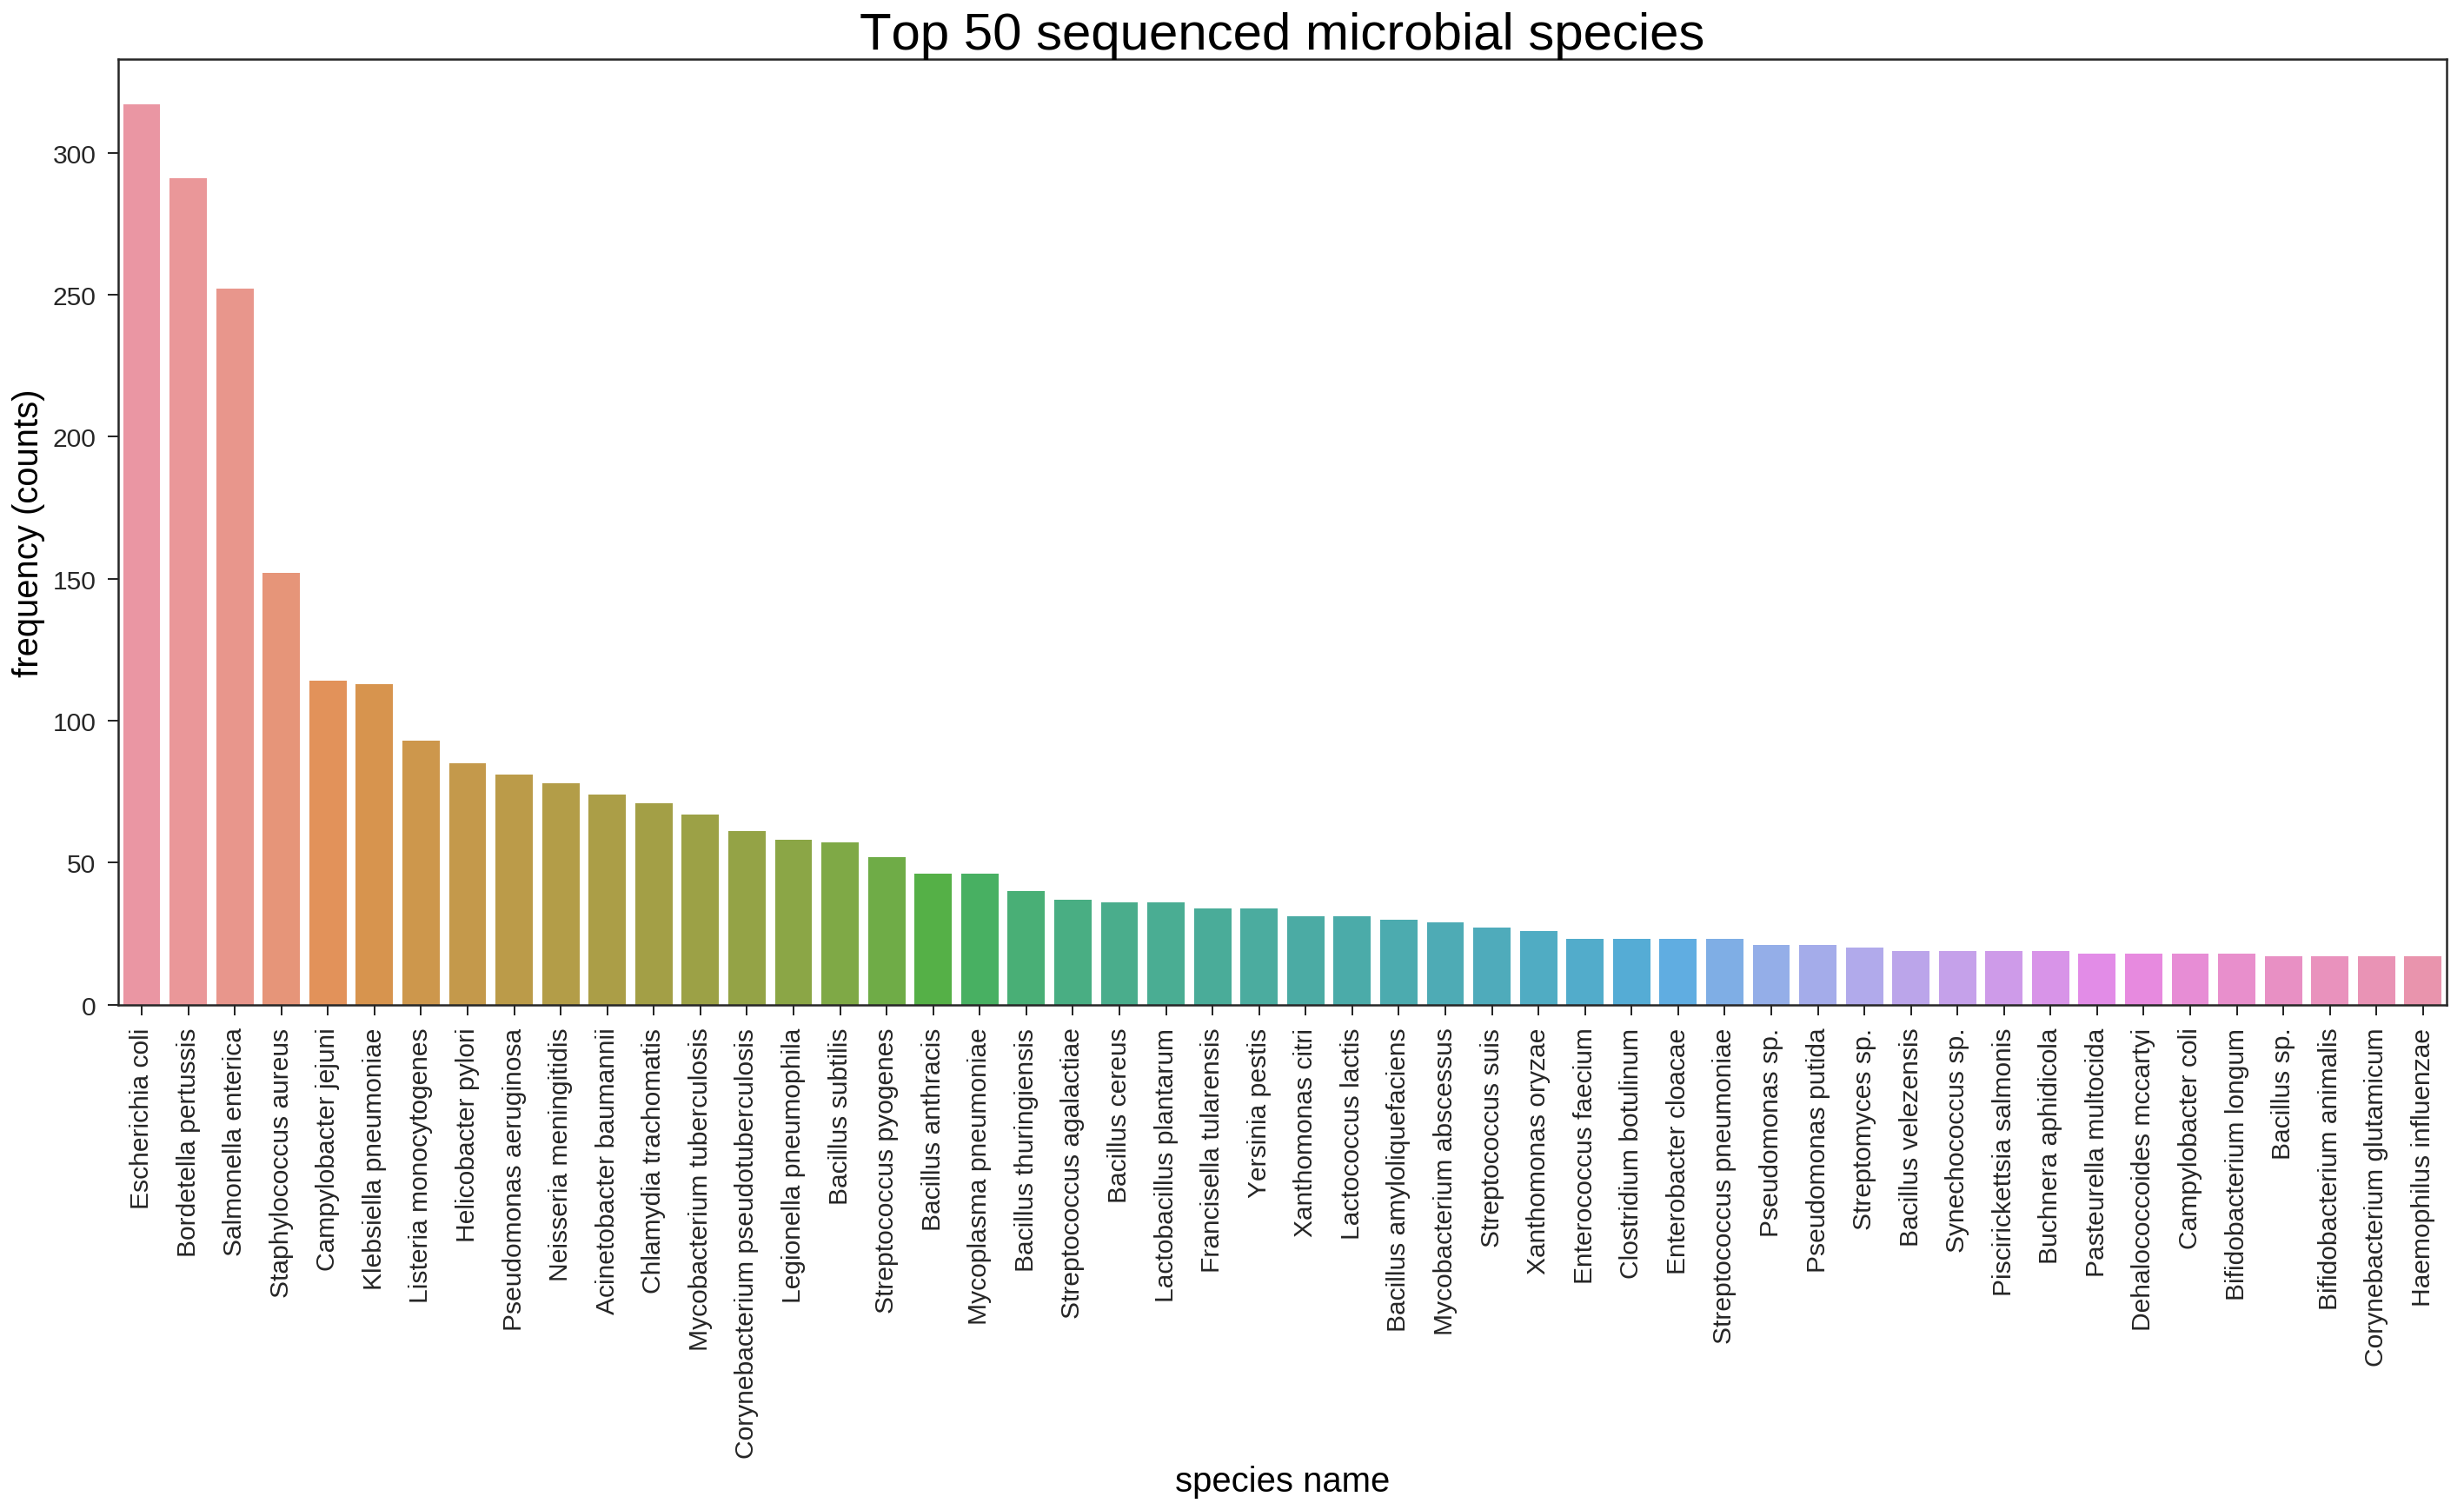

In [32]:
fig = plt.subplot()
#xlabels = ['name %i' % i for i in range(dd)]
#sns.countplot(x=s.values, data=s, palette="Greens_d");
sns.set_context({"figure.figsize": (24, 10)})
g = sns.barplot(x='name', y='frequency', data=dd.head(50))
#g.set_xticks('name')
fig.set_xticklabels(dd['name'], rotation=90)
fig.set_xlabel('species name', fontsize=20, color="k")
fig.set_ylabel('frequency (counts)',  fontsize=20, color="k")
fig.set_title('Top 50 sequenced microbial species', fontsize=30, color="k")

## Variation of GC content within species

GC content variance for the whole dataset

In [33]:
np.var(MyGC_sep.GC)

163.2742190743499

### Calculate the variance in genomic GC content for each species

We will create a list with unique names, as before, and for each occurrence of a name in the dataframe will take the GC content value, store them all in a separate temporary list and calculate the variance. Then store the groups name with the variance in a new list:

In [34]:
species2 = [] ## Get unigue species names

for entry in MyGC_genome.itertuples():
    name = ' '.join(entry[1].split()[:-2])
    host_name = ' '.join(name.split()[:2])  ## Select only the first word of the entry
    if not 'Bacterium' in host_name:  ## I noticed entries with these names creeping up, so I exlude them here
        if not 'Endosymbiont' in host_name:
            if not 'endosymbiont' in host_name:
                species2.append(host_name)

In [35]:
names_var = []

for s in species2:  ## For each unique name in the names list
    count = []  ## list to hold the GC values
    sp = str(s)
    for entry in MyGC_genome.itertuples():  ## Get the name
        name = ' '.join(entry[1].split()[:-2])
        host_name = ' '.join(name.split()[:2])
        if sp in host_name:
            count.append([entry.GC])  ## Store GC value in "count"

    n_var = np.var(count)  ## Calculate the variance of the entries in "count"
    names_var.append([s, n_var])  ## Store the variance value with the unique name

In [36]:
s2 = pd.DataFrame.from_records(names_var)
s2.columns = ['name', 'variance']
dd2 = s2.sort_values('variance', ascending=0)
dd2[dd2.variance>0].head(10) ## change this number to see less or more
dd2.head(10)

name    variance
4833  Burkholderiales bacterium  122.979278
1360  Burkholderiales bacterium  122.979278
2113            Actinomyces sp.   85.236947
2472            Actinomyces sp.   85.236947
5108            Actinomyces sp.   85.236947
4908           Sphingopyxis sp.   82.413969
797            Sphingopyxis sp.   82.413969
6593           Sphingopyxis sp.   82.413969
695        Candidatus Tremblaya   61.858451
1445       Candidatus Tremblaya   61.858451

In [37]:
dd3 = s2.sort_values('variance', ascending=True)
dd3[dd2.variance>0.1].head(30)

/home/atol/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


name  variance
2873          Paenibacillus larvae  0.103281
3636          Paenibacillus larvae  0.103281
5286          Paenibacillus larvae  0.103281
5459          Paenibacillus larvae  0.103281
1874          Paenibacillus larvae  0.103281
6287      Burkholderia cenocepacia  0.108564
680       Burkholderia cenocepacia  0.108564
679       Burkholderia cenocepacia  0.108564
6286      Burkholderia cenocepacia  0.108564
6288      Burkholderia cenocepacia  0.108564
678       Burkholderia cenocepacia  0.108564
2069      Burkholderia cenocepacia  0.108564
5810             Myxococcus fulvus  0.109703
447              Myxococcus fulvus  0.109703
1814                  Hafnia alvei  0.112021
6543                  Hafnia alvei  0.112021
6034                  Hafnia alvei  0.112021
4460      Flavobacterium columnare  0.113224
5060      Flavobacterium columnare  0.113224
756       Flavobacterium columnare  0.113224
608       Flavobacterium columnare  0.113224
1071      Flavobacterium columnare  0.113224
6189  Stenotrophomonas maltophilia  0.116743
5895  Stenotrophomonas maltophilia  0.116743
360   Stenotrophomonas maltophilia  0.116743
4438  Stenotrophomonas maltophilia  0.116743
2662  Stenotrophomonas maltophilia  0.116743
975   Stenotrophomonas maltophilia  0.116743
2302  Stenotrophomonas maltophilia  0.116743
5679  Stenotrophomonas maltophilia  0.116743

## Regression

### Genomes GC vs Length

In [38]:
## HC0=Heteroskedasticity-corrected OLS
## HC3= Heteroskedasticity-corrected and good for small samples  --throws memory error
MyGC_genome_con = sm.add_constant(MyGC_genome.Length) # Adds a constant so we can fit the intercept 
gen_host_corrected = sm.OLS(MyGC_genome.GC, MyGC_genome_con).fit(cov_type='HC0', use_t=True)
print(gen_host_corrected.summary())

                            OLS Regression Results                            
Dep. Variable:                     GC   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     3537.
Date:                Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                        14:23:10   Log-Likelihood:                -25179.
No. Observations:                6671   AIC:                         5.036e+04
Df Residuals:                    6669   BIC:                         5.038e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.1236      0.284    116.619      0.0

### OLS corrected for heteroskedasticity for Plasmid-Host:

In [39]:
X = dfm_GC.Host
y = dfm_GC.Plasmid
X = sm.add_constant(X) # Adds a constant so we can fit the intercept
Pl_host_result_ols = sm.OLS(y, X).fit(cov_type='HC0', use_t=True)
print("Model parameters: \n%s\n" % Pl_host_result_ols.params)
print(Pl_host_result_ols.summary())

Model parameters: 
const   -0.435475
Host     0.962651
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                Plasmid   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                 2.088e+05
Date:                Fri, 06 Oct 2017   Prob (F-statistic):               0.00
Time:                        14:23:14   Log-Likelihood:            -1.4656e+05
No. Observations:               49785   AIC:                         2.931e+05
Df Residuals:                   49783   BIC:                         2.931e+05
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

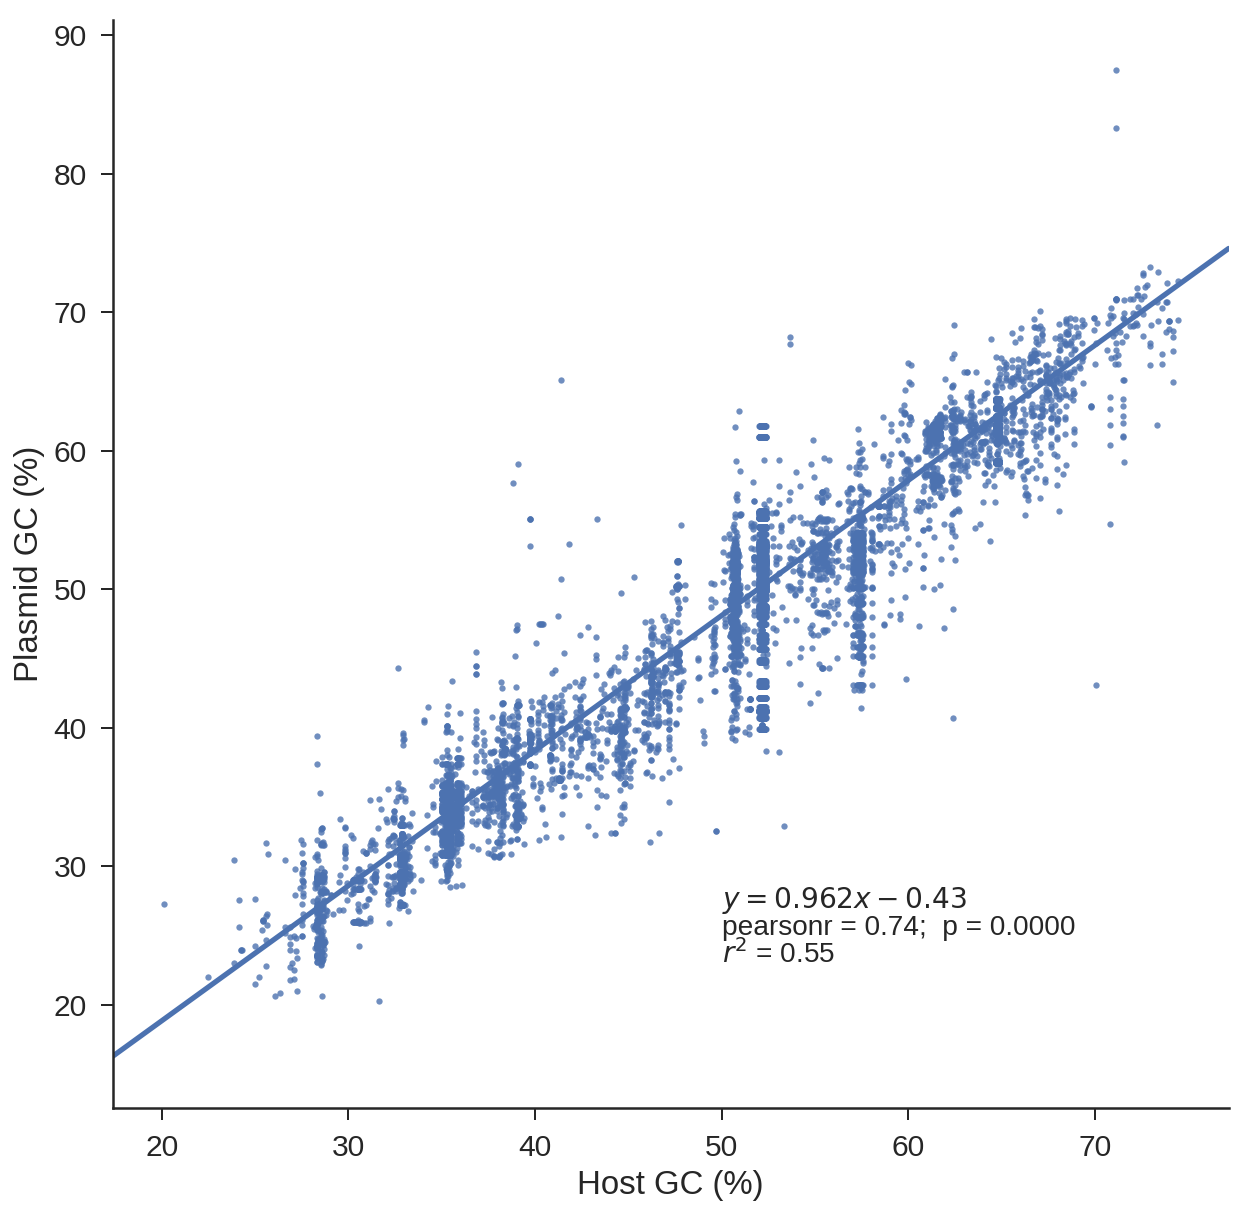

In [40]:
pr = stats.pearsonr(dfm_GC.Host, dfm_GC.Plasmid)
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(dfm_GC.Host, dfm_GC.Plasmid)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
axes = plt.gca()
sns.regplot(dfm_GC.Host, dfm_GC.Plasmid, scatter_kws={'s':10}, ax=ax, robust=True)
ax.annotate('pearsonr = %.2f;  p = %.4f' %(pr[0], pr[1]), xy=(50, 25), fontsize=14)
ax.annotate('$r^2$ = %.2f' %Pl_host_result_ols.rsquared, xy=(50, 23), fontsize=14)
ax.annotate('$y=%3.5sx%3.5s$'%(slope, intercept), xy=(50, 27), fontsize=14)
ax.set_xlabel('Host GC (%)')
ax.set_ylabel('Plasmid GC (%)')
matplotlib.pyplot.savefig('Images2/plasmid_host.png', bbox_inches='tight')
matplotlib.pyplot.savefig('Images2/plasmid_host.pdf', format='pdf', dpi=300, bbox_inches='tight')
sns.despine()

### Phages GC content vs Host GC content

In [41]:
X2 = dfm_phage_GC.Host
y2 = dfm_phage_GC.Phage
X2 = sm.add_constant(X2) # Adds a constant so we can fit the intercept
phages_corrected = sm.OLS(y2, X2).fit(cov_type='HC3', use_t=True)
print phages_corrected.summary()

                            OLS Regression Results                            
Dep. Variable:                  Phage   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     919.5
Date:                Fri, 06 Oct 2017   Prob (F-statistic):          4.32e-129
Time:                        14:33:39   Log-Likelihood:                -1766.1
No. Observations:                 693   AIC:                             3536.
Df Residuals:                     691   BIC:                             3545.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6211      1.088      1.490      0.1

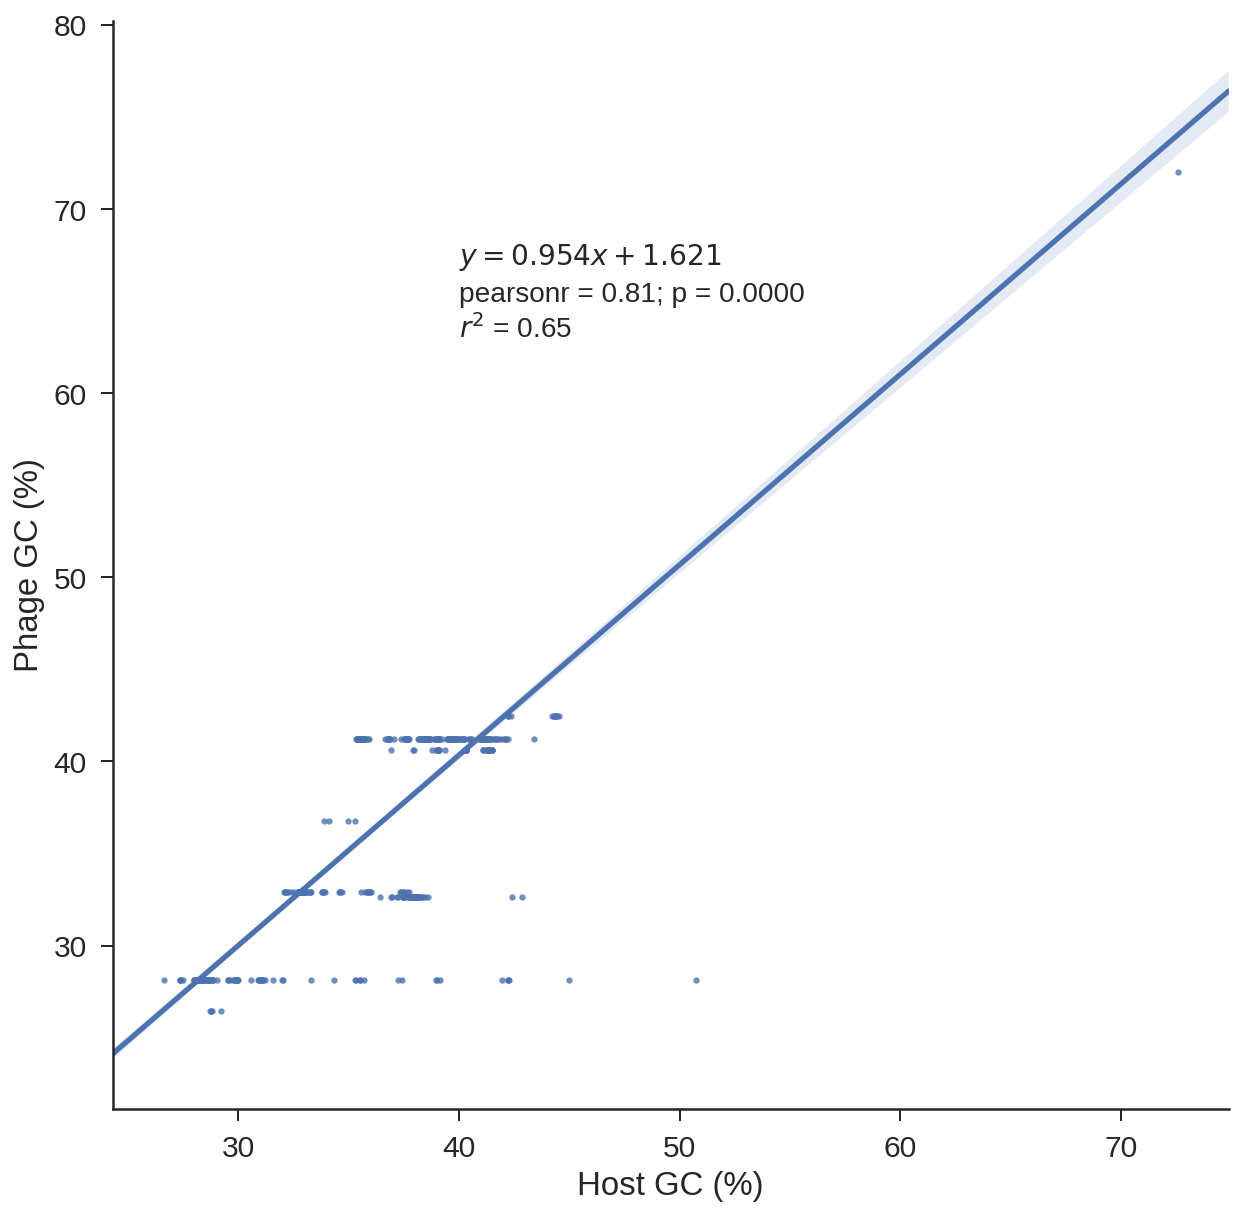

In [42]:
pr_phage = stats.pearsonr(dfm_phage_GC.Host, dfm_phage_GC.Phage)
slope, intercept, r_value, p_value, slope_std_error = stats.linregress(dfm_phage_GC.Host, dfm_phage_GC.Phage)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
axes = plt.gca()
sns.regplot(dfm_phage_GC.Host, dfm_phage_GC.Phage, scatter_kws={'s':10}, ax=ax, robust=True)
ax.annotate('pearsonr = %.2f; p = %.4f' %(pr_phage[0], pr_phage[1]), xy=(40, 65), fontsize=14)
ax.annotate('$r^2$ = %.2f' %pr_phage[0]**2, xy=(40, 63), fontsize=14)
ax.annotate('$y=%3.5sx+%3.5s$'%(slope, intercept), xy=(40, 67), fontsize=14)
ax.set_xlabel('Host GC (%)')
ax.set_ylabel('Phage GC (%)')
matplotlib.pyplot.savefig('Images2/phage_host.png', bbox_inches='tight')
matplotlib.pyplot.savefig('Images2/phage_host.pdf', format='pdf', dpi=300, bbox_inches='tight')
sns.despine()

## Interactive plots

In [43]:
from bokeh.io import push_notebook, output_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, BoxZoomTool, PanTool

In [44]:
# Display bokeh graphics in this notebook
output_notebook()

Loading BokehJS ...

In [45]:
desc_int = []
## Get the name from the description
for entry in MyGC_genome.itertuples():
    name = ' '.join(entry[1].split()[:-2])
    host_name = ' '.join(name.split()[:2])
    length = entry.Length
    gc = entry.GC
    desc_int.append([host_name, length, gc])

In [46]:
source = ColumnDataSource(dict(
    x = [i[1] for i in desc_int],
    y = [i[2] for i in desc_int],
    name = [i[0] for i in desc_int]))

# make the hover tool to show custom information
hover = HoverTool(tooltips = "@name")

# create a new plot with tools
p = figure(plot_width=900, plot_height=700, tools=[hover, 'reset', 'zoom_in', 'zoom_out', 'pan', 'box_zoom'])

# add a circle renderer to create the scatter plot
p.circle('x', 'y', size=4, source=source)

show(p, browser="opera") # Show the results. Change the browser here accordingly

### Plasmids

In [47]:
plasm_int = []
## Get the name from the description
for entry in MyGC_plasmid.itertuples():
    name = ' '.join(entry[1].split()[:-2])
    host_name = ' '.join(name.split()[:2])
    length = entry.Length
    gc = entry.GC
    plasm_int.append([host_name, length, gc])

In [48]:
source = ColumnDataSource(dict(
    x = [i[1] for i in plasm_int],
    y = [i[2] for i in plasm_int],
    name = [i[0] for i in plasm_int]))

# make the hover tool to show custom information
hover = HoverTool(tooltips = "@name")

# create a new plot with tools
p = figure(plot_width=900, plot_height=700, tools=[hover, 'reset', 'zoom_in', 'zoom_out', 'pan', 'box_zoom'])

# add a circle renderer to create the scatter plot
p.circle('x', 'y', size=4, source=source)

show(p, browser="opera") # Show the results. Change the browser here accordingly

### Plasmid - Host

We will use **Pairs_length**, **Pairs_GC** and **Pairs_name** from above

There is a memory error from the cell bellow due to a low io data rate limit. To avoid it, start jupyter notebook with:  
*jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000*

In [62]:
source = ColumnDataSource(dict(
    host = [i[0] for i in Pairs_GC],
    plasmid = [i[1] for i in Pairs_GC],
    name = [i for i in Pairs_name]))

# make the hover tool to show custom information
hover = HoverTool(tooltips = "@name")

# create a new plot with tools
p = figure(plot_width=900, plot_height=700, tools=[hover, 'reset', 'zoom_in', 'zoom_out', 'pan', 'box_zoom'])

# add a circle renderer to create the scatter plot
p.circle('host', 'plasmid', size=4, source=source)

show(p, browser="opera") # Show the results. Change the browser here accordingly